# ESDA

Exploratory Spatial Data Analysis using PySal

Useful links: 

- http://pysal.org/notebooks/viz/splot/esda_morans_viz.html

- https://towardsdatascience.com/what-is-exploratory-spatial-data-analysis-esda-335da79026ee

- http://ljwolf.org/post/spatial_acf/

- Original LISA article: https://dces.webhosting.cals.wisc.edu/wp-content/uploads/sites/128/2013/08/W4_Anselin1995.pdf

It's recommended the use of the following versions of the spatial libraries:

- libpysal=4.2.2
- esda=2.2.1

Using more up to date libraries can lead to unexpected errors in Moran Local funcions.

Import libraries

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import libpysal
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local,Moran_BV,Moran_Local_BV
from splot.esda import moran_scatterplot,plot_local_autocorrelation,lisa_cluster,plot_moran_bv
import geopandas as gpd
import glob
%matplotlib inline

Loading shp file for cities in Brazil

<AxesSubplot:>

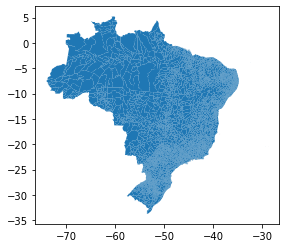

In [2]:
root = "../"
gdf = gpd.read_file(root + 'Maps/BRMUE250GC_SIR.shp')
gdf.plot()

## Spatial autocorrelation
Spatial autocorrelation describes the presence or absence of spacial variations in a given variable.

- Positive spatial autocorrelation: areas close to each other have similar values (High-high or Low-low)
- Negative spatial autocorrelation: neighbourhood areas are different from each other (Low-high or High-low) 

There are two types of spatial autocorrelation:

- Global: focuses on the overall trend in the dataset and gives us information about the degree of clustering 
- Local: detects variability and divergence in the dataset

Calculating contiguity weights (spacial similarity) with Queen.from_dataframe (http://darribas.org/gds_scipy16/ipynb_md/03_spatial_weights.html)

"Spatial similarity relation refers to similarity among and between objects on maps or in geographic space"
(source: https://www.sciencedirect.com/science/article/pii/S1674984715000191)

Spatial weights are how we determine the area’s neighborhood

In [3]:
"""
weight_files = glob.glob("weights.gal")

# there's a weights file
if len(weight_files) > 0:
    w = libpysal.io.open('weights.gal', 'r').read()
else:
    w = Queen.from_dataframe(gdf)
    #w.transform = 'r'
    # save a weights file
    fo = libpysal.io.open('weights.gal', 'w')
    fo.write(w)
    fo.close()
"""

'\nweight_files = glob.glob("weights.gal")\n\n# there\'s a weights file\nif len(weight_files) > 0:\n    w = libpysal.io.open(\'weights.gal\', \'r\').read()\nelse:\n    w = Queen.from_dataframe(gdf)\n    #w.transform = \'r\'\n    # save a weights file\n    fo = libpysal.io.open(\'weights.gal\', \'w\')\n    fo.write(w)\n    fo.close()\n'

In [4]:
from numpy import load, save
from libpysal.weights import WSP
import scipy

In [5]:
weight_files = glob.glob("data.npy")

if len(weight_files) > 0:
    data = load("data.npy")
    spar = scipy.sparse.csc_matrix(data)
    wsp = WSP(spar)
    w = wsp.to_W()
    print("Loaded preexisting data.npy")
else:
    w = Queen.from_dataframe(gdf)
    w.transform = 'r'
    wsp = w.to_WSP()
    data = wsp.sparse.toarray()
    save("data.npy", data)
    print("Created data.npy")

Loaded preexisting data.npy


C:\Users\marco\Anaconda3\envs\spatial_eda\lib\site-packages\libpysal\weights\weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 1773, 2170.
  warnings.warn(message)


Save file to Dashboard:

In [6]:
dashboard_files = glob.glob(root + "Dashboard/data.npy")
if len(dashboard_files) == 0:
    save(root + "Dashboard/data.npy", data)

In [7]:
w.pct_nonzero

0.10605148602204953

In [8]:
w.n

5572

Taking a look at gdf 

In [9]:
gdf

,NM_MUNICIP,CD_GEOCMU,geometry
0,ABADIA DE GOIÁS,5200050,"POLYGON ((-49.44440 -16.71747, -49.44435 -16.7..."
1,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.43840 -18.16570, -47.43588 -18.1..."
2,ABADIÂNIA,5200100,"POLYGON ((-48.84178 -16.00488, -48.79639 -16.0..."
3,ABAETÉ,3100203,"POLYGON ((-45.16777 -18.89073, -45.16719 -18.8..."
4,ABAETETUBA,1500107,"POLYGON ((-48.83139 -1.56352, -48.82910 -1.571..."
...,...,...,...
5567,XIQUE-XIQUE,2933604,"POLYGON ((-42.38095 -10.24423, -42.37974 -10.2..."
5568,ZABELÊ,2517407,"POLYGON ((-37.14957 -8.02374, -37.14928 -8.024..."
5569,ZACARIAS,3557154,"POLYGON ((-49.99275 -21.03884, -49.99214 -21.0..."
5570,ZÉ DOCA,2114007,"POLYGON ((-45.92061 -3.02780, -45.91877 -3.028..."


CD_GEOCMU is the 7-digit city code, we need to convert it to the standard 6-digit code

In [10]:
cadmun = pd.read_csv(root + 'CSV/Cadmun/CADMUN.csv')
cadmun = cadmun[["MUNCOD", "MUNCODDV"]]
gdf["CD_GEOCMU"] = gdf["CD_GEOCMU"].astype(int)
gdf_city = pd.merge(gdf, cadmun, left_on="CD_GEOCMU", right_on="MUNCODDV", how="left")

In [11]:
gdf_city.head()

,NM_MUNICIP,CD_GEOCMU,geometry,MUNCOD,MUNCODDV
0,ABADIA DE GOIÁS,5200050,"POLYGON ((-49.44440 -16.71747, -49.44435 -16.7...",520005.0,5200050.0
1,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.43840 -18.16570, -47.43588 -18.1...",310010.0,3100104.0
2,ABADIÂNIA,5200100,"POLYGON ((-48.84178 -16.00488, -48.79639 -16.0...",520010.0,5200100.0
3,ABAETÉ,3100203,"POLYGON ((-45.16777 -18.89073, -45.16719 -18.8...",310020.0,3100203.0
4,ABAETETUBA,1500107,"POLYGON ((-48.83139 -1.56352, -48.82910 -1.571...",150010.0,1500107.0


Merging with suicide CSV to get SUICIDE_RATE for each city

In [12]:
suicide = pd.read_csv(root + 'CSV/Suicide/suicide_rates_08_18.csv', sep=',', index_col=0)
suicide['AVG_SUICIDE_RATE'] = np.mean(suicide.filter(regex=("RATE_*")), axis=1)
suicide.head()

,MUNCOD,RATE_08,RATE_09,RATE_10,RATE_11,RATE_12,RATE_13,RATE_14,RATE_15,RATE_16,RATE_17,RATE_18,AVG_SUICIDE_RATE
0,110001,20.344224,8.212203,8.189337,4.127456,12.464166,7.773632,3.898332,11.728829,7.841292,11.793844,4.316485,9.153618
1,110002,9.458389,2.338060,4.427031,4.368243,9.703818,1.974938,4.860976,4.789226,5.665936,9.315758,1.883807,5.344198
2,110003,0.000000,14.936520,0.000000,0.000000,0.000000,15.396459,0.000000,31.471282,15.900779,0.000000,18.389114,8.735832
3,110004,5.110972,7.626311,2.544497,1.266480,5.042229,1.164646,5.776607,6.878683,10.241588,5.649271,9.432516,5.521254
4,110005,0.000000,0.000000,11.743981,0.000000,11.868028,0.000000,0.000000,11.119760,11.136478,5.576001,6.081245,5.229590


In [13]:
suicide = suicide[['MUNCOD', 'AVG_SUICIDE_RATE']]
result = pd.merge(gdf_city, suicide, left_on="MUNCOD", right_on="MUNCOD", how="left")
result = result[["NM_MUNICIP", "CD_GEOCMU", "geometry", "AVG_SUICIDE_RATE"]]
result['AVG_SUICIDE_RATE'] = result['AVG_SUICIDE_RATE'].fillna(0) #filling null values with 0

In [14]:
result.head(5)

,NM_MUNICIP,CD_GEOCMU,geometry,AVG_SUICIDE_RATE
0,ABADIA DE GOIÁS,5200050,"POLYGON ((-49.44440 -16.71747, -49.44435 -16.7...",14.133386
1,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.43840 -18.16570, -47.43588 -18.1...",15.752620
2,ABADIÂNIA,5200100,"POLYGON ((-48.84178 -16.00488, -48.79639 -16.0...",8.328028
3,ABAETÉ,3100203,"POLYGON ((-45.16777 -18.89073, -45.16719 -18.8...",12.879358
4,ABAETETUBA,1500107,"POLYGON ((-48.83139 -1.56352, -48.82910 -1.571...",1.619971


Defining the y dimension

In [15]:
y = result['AVG_SUICIDE_RATE'].values
y.shape

(5572,)

### Global spatial autocorrelation

Calculating Moran's I (measure of global spatial autocorrelation)

In [16]:
from esda.moran import Moran

moran = Moran(y, w)
moran.I

('WARNING: ', 1773, ' is an island (no neighbors)')
('WARNING: ', 2170, ' is an island (no neighbors)')


0.4612716123019057

Evaluating the significance:

In [17]:
print(moran.EI)
print(moran.p_norm)
print()
print(moran.EI_sim)
print(moran.p_sim)

-0.0001795009872554299
0.0

-9.279202797602762e-05
0.001


We conclude that there is a **positive spatial autocorrelation** in this dataset, which is **significant** against the null hypothesis that attribute values are randomly distributed (p-value < 1%)

Visualizing the global spatial autocorrelation

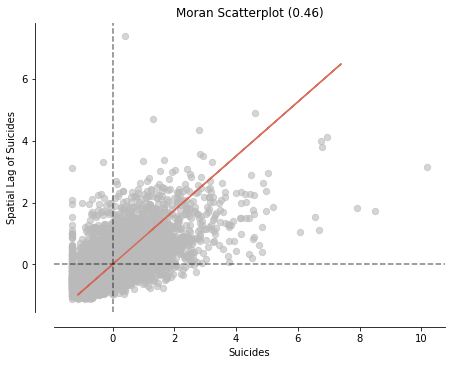

In [18]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
ax.set_xlabel('Suicides')
ax.set_ylabel('Spatial Lag of Suicides')
plt.show()

### Local spatial autocorrelation

Calculating Moran Local

In [19]:
"""
w_test = libpysal.io.open(libpysal.examples.get_path("desmith.gal")).read()
fo = libpysal.io.open('w_test.gal', 'w')
fo.write(w_test)
fo.close()

f = libpysal.io.open(libpysal.examples.get_path("desmith.txt"))

y_test = np.array(f.by_col['z'])

lm = Moran_Local(y_test, w_test, transformation = "r", permutations = 99)

print(len(y_test), w_test.n)
print(len(y), w.n)
"""

'\nw_test = libpysal.io.open(libpysal.examples.get_path("desmith.gal")).read()\nfo = libpysal.io.open(\'w_test.gal\', \'w\')\nfo.write(w_test)\nfo.close()\n\nf = libpysal.io.open(libpysal.examples.get_path("desmith.txt"))\n\ny_test = np.array(f.by_col[\'z\'])\n\nlm = Moran_Local(y_test, w_test, transformation = "r", permutations = 99)\n\nprint(len(y_test), w_test.n)\nprint(len(y), w.n)\n'

In [20]:
w

In [21]:
y

array([14.13338629, 15.75262043,  8.32802795, ...,  3.89499104,
        4.15817467, 14.12823006])

In [22]:
moran_loc = Moran_Local(y, w)

C:\Users\marco\Anaconda3\envs\spatial_eda\lib\site-packages\esda\moran.py:886: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


Plotting Moran's Local Scatter Plot

The scatter plot divides the areas into the four groups:
- High-high: top right
- High-low: bottom right
- Low-low: bottom left
- Low-high: top left


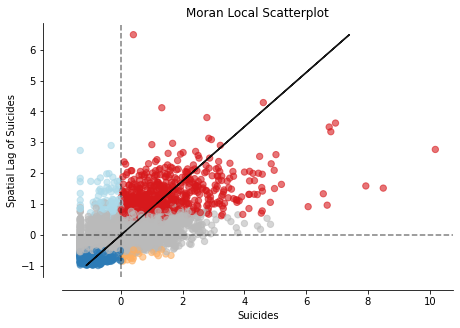

In [23]:
fig, ax = moran_scatterplot(moran_loc, p=0.05) # p: points colored by significance
ax.set_xlabel('Suicides')
ax.set_ylabel('Spatial Lag of Suicides')
plt.show()

Visualizing the clusters on a map

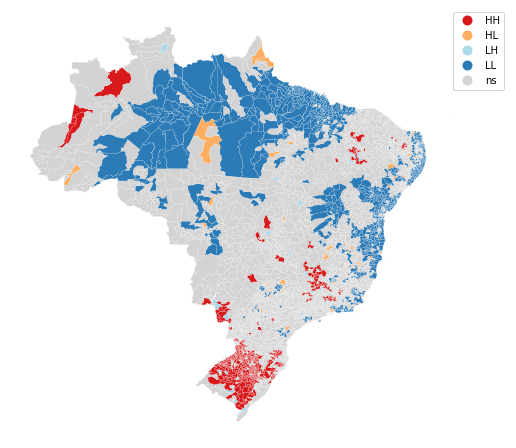

In [24]:
lisa_cluster(moran_loc, result, p=0.05, figsize=(9,9))
plt.show()

Combined visualizations 

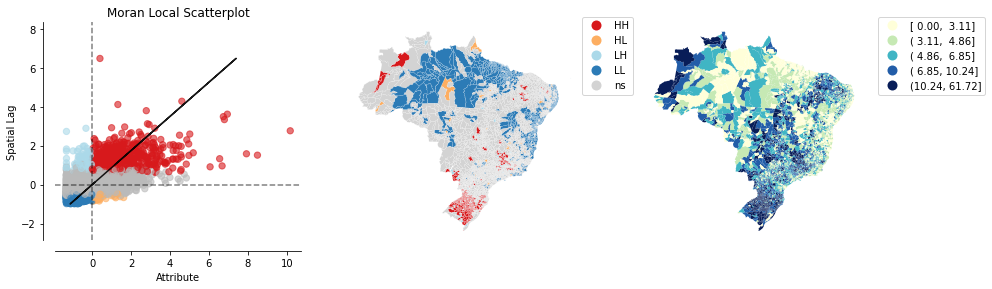

In [25]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(moran_loc, result, 'AVG_SUICIDE_RATE')
plt.show()

Choropleth map of average suicide rates in Brazil (2008 - 2018)

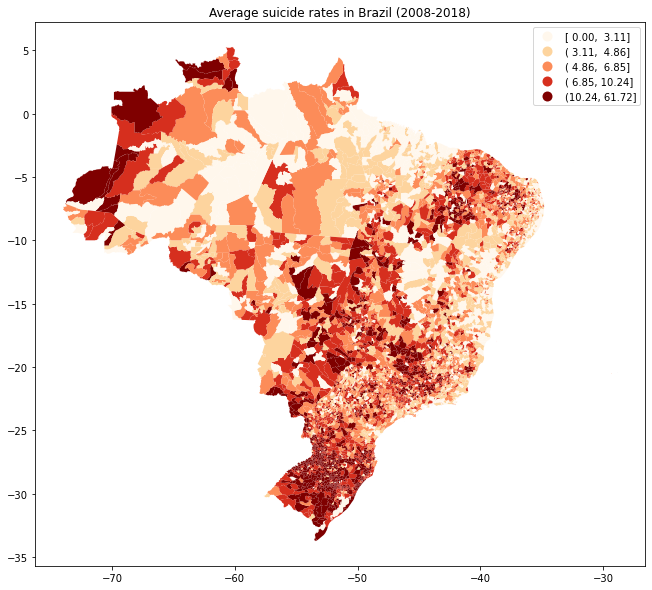

In [26]:
fig = result.plot(column='AVG_SUICIDE_RATE', legend=True, figsize=(15, 10), cmap='OrRd', scheme='quantiles')
plt.title("Average suicide rates in Brazil (2008-2018)")
plt.show()

<AxesSubplot:>

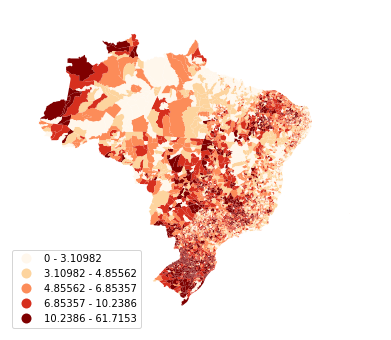

In [27]:
import geoplot as gplt
gplt.choropleth(result, hue='AVG_SUICIDE_RATE', cmap='OrRd', linewidth=0, scheme='quantiles', legend=True)

## Bivariate Moran Statistics

Inspecting the relationship of two variables and their position in space 

Loading disease data and merging with gdf

We selected the highest correlated variable with the suicide target (in this case: TRANSTORNOS_DE_HUMOR_[AFETIVOS] - mental disorder)

In [28]:
disease = pd.read_csv(root + 'CSV/TabNet/Internacoes_Rate/TRANSTORNOS_DE_HUMOR_[AFETIVOS].csv', sep=',', index_col=0)
disease['AVG_DISEASE_RATE'] = np.mean(disease.filter(regex=("RATE_*")), axis=1)

In [29]:
disease = disease[['MUNCOD', 'AVG_DISEASE_RATE']]
result = pd.merge(gdf_city, disease, left_on="MUNCOD", right_on="MUNCOD", how="left")
result = pd.merge(result, suicide, left_on="MUNCOD", right_on="MUNCOD", how="left")
result = result[["NM_MUNICIP", "CD_GEOCMU", "geometry", "AVG_SUICIDE_RATE", 'AVG_DISEASE_RATE']]
result['AVG_SUICIDE_RATE'] = result['AVG_SUICIDE_RATE'].fillna(0)
result['AVG_DISEASE_RATE'] = result['AVG_DISEASE_RATE'].fillna(0)

In [30]:
result.head()

,NM_MUNICIP,CD_GEOCMU,geometry,AVG_SUICIDE_RATE,AVG_DISEASE_RATE
0,ABADIA DE GOIÁS,5200050,"POLYGON ((-49.44440 -16.71747, -49.44435 -16.7...",14.133386,71.409084
1,ABADIA DOS DOURADOS,3100104,"POLYGON ((-47.43840 -18.16570, -47.43588 -18.1...",15.752620,22.249913
2,ABADIÂNIA,5200100,"POLYGON ((-48.84178 -16.00488, -48.79639 -16.0...",8.328028,26.503983
3,ABAETÉ,3100203,"POLYGON ((-45.16777 -18.89073, -45.16719 -18.8...",12.879358,17.925749
4,ABAETETUBA,1500107,"POLYGON ((-48.83139 -1.56352, -48.82910 -1.571...",1.619971,4.520506


Bivariate Moran Statistics describe the correlation between one variable and the spatial lag of another variable
 
IMPORTANT: Bivariate Moran Statistics do not take the inherent correlation between the two variables at the same location into account.

In [31]:
x = result['AVG_SUICIDE_RATE'].values
y = result['AVG_DISEASE_RATE'].values

Calculating Moran's BV I

A single statistic (and accompanying (p)-values computed using permutation methods) that relates the values of attribute (x) to the lag of (y).

In [32]:
moran_bv = Moran_BV(y, x, w)
moran_bv.I

0.35113083745616697

Plotting Moran BV

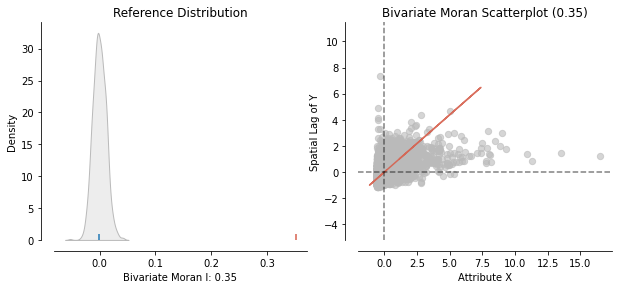

In [33]:
plot_moran_bv(moran_bv)
plt.show()

Calculating BV Moran Local

C:\Users\marco\Anaconda3\envs\spatial_eda\lib\site-packages\esda\moran.py:1121: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim


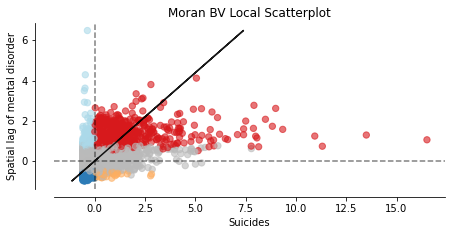

In [34]:
moran_loc_bv = Moran_Local_BV(y, x, w)
fig, ax = moran_scatterplot(moran_loc_bv, p=0.05)
ax.set_xlabel('Suicides')
ax.set_ylabel('Spatial lag of mental disorder')
plt.show()

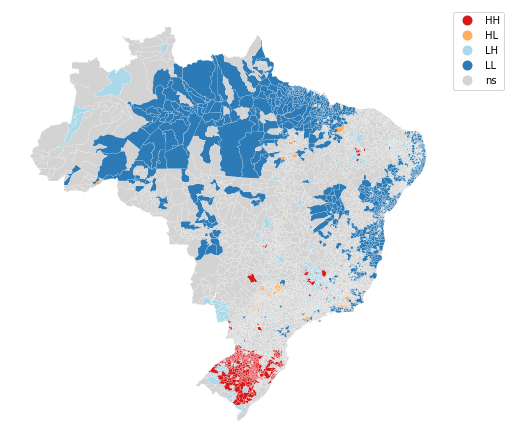

In [35]:
lisa_cluster(moran_loc_bv, result, p=0.05, figsize=(9,9))
plt.show()

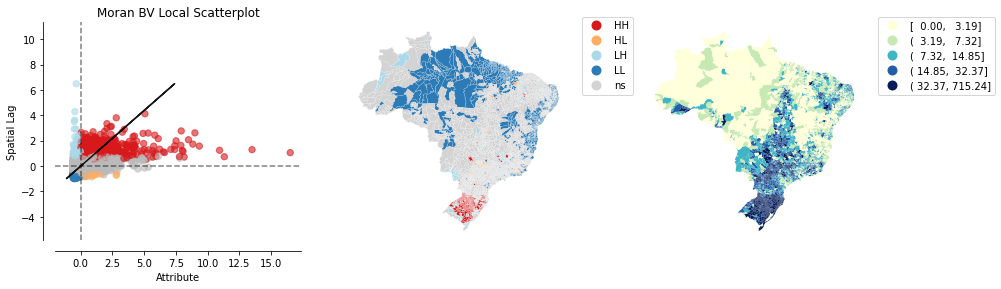

In [36]:
plot_local_autocorrelation(moran_loc_bv, result, 'AVG_DISEASE_RATE')
plt.show()

## Table of Moran BV I (Suicide vs. Disease)

Let's see the Moran BV I value for each disease:

In [37]:
import re

In [38]:
path = root + "CSV/TabNet/Internacoes_Rate/"
all_files = glob.glob(path + "*.csv")

In [39]:
morans = []
diseases = []
for file in all_files:
    # disease name
    disease = file
    disease = disease.split('\\')[1].split('.csv')[0]
    # read file
    rates = pd.read_csv(file.replace('\\', '/'), sep=',', index_col=0)
    # calculate average
    rates['AVG_DISEASE_RATE'] = np.mean(rates.filter(regex=("RATE_*")), axis=1)
    # merges with suicide and gdf
    rates = rates[['MUNCOD', 'AVG_DISEASE_RATE']]
    result = pd.merge(gdf_city, rates, left_on="MUNCOD", right_on="MUNCOD", how="left")
    result = pd.merge(result, suicide, left_on="MUNCOD", right_on="MUNCOD", how="left")
    result = result[["NM_MUNICIP", "CD_GEOCMU", "geometry", "AVG_SUICIDE_RATE", 'AVG_DISEASE_RATE']]
    # fill NaN's with 0
    result['AVG_SUICIDE_RATE'] = result['AVG_SUICIDE_RATE'].fillna(0)
    result['AVG_DISEASE_RATE'] = result['AVG_DISEASE_RATE'].fillna(0)

    x = result['AVG_SUICIDE_RATE'].values
    y = result['AVG_DISEASE_RATE'].values

    moran_bv = Moran_BV(y, x, w)
    
    diseases.append(disease)
    morans.append(moran_bv.I)

C:\Users\marco\Anaconda3\envs\spatial_eda\lib\site-packages\esda\moran.py:373: RuntimeWarning: invalid value encountered in true_divide
  zx = (x - x.mean()) / x.std(ddof=1)


In [40]:
morans_data = {'Doenças': diseases, 'Moran BV I': morans}
morans_data = pd.DataFrame(data=morans_data)
morans_data.sort_values(by=['Moran BV I'], ascending=False).head(30)

,Doenças,Moran BV I
16,ARTROSE,0.370555
160,NEOPLASIA_MALIGNA_DE_TRAQUÉIA_BRÔNQUIOS_E_PULMÕES,0.355419
303,TRANSTORNOS_DE_HUMOR_[AFETIVOS],0.351131
22,BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM_OBSTR_CRÔNIC,0.318824
50,DOENÇAS_DO_APÊNDICE,0.307730
175,NEOPL_MALIG_OUTR_LOCALIZ_MAL_DEF_SECUN_E_NÃO_E...,0.303648
31,COLELITÍASE_E_COLECISTITE,0.298915
310,TRANST_MENTAIS_E_COMPORTAMENTAIS_DEV_USO_DE_ÁL...,0.297931
70,EMBOLIA_E_TROMBOSE_ARTERIAIS,0.295663
307,TRANST_DISCAIS_CERVIC_E_OUTR_TRANST_DISC_INTER...,0.288315
